In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 안 깨지게 하는 코드
from matplotlib import rc
rc('font', family='Malgun Gothic') # Windows
plt.rcParams['axes.unicode_minus'] = False

# 머신러닝 모델링
from sklearn.model_selection import train_test_split # 데이터를 훈련/테스트 세트로 나누는 데 필요
from sklearn.linear_model import LinearRegression    # 선형 회귀 모델을 사용할 때
from sklearn.metrics import mean_squared_error, r2_score # 모델 성능 평가 지표

# 시계열 분석 모델 (Statsmodels)
import statsmodels.api as sm # ARIMA 같은 통계 모델을 쓸 때 sm으로 줄여 써

# 시계열 예측 모델 (Prophet)
from prophet import Prophet # 페이스북 Prophet은 보통 클래스 형태로 임포트



In [15]:
import pandas as pd

# 1) CSV 또는 엑셀에서 데이터 읽어오기 (네 파일 경로 맞게 변경)
df_wide = pd.read_csv('연도별지하철요금.csv', encoding='utf-8-sig')

# 2) 열 이름 확인 (안 맞으면 코드 수정 필요)
print(df_wide.columns)

# 3) Wide to long 형태 변환 (melt 활용)
df_long = df_wide.melt(id_vars=['연도(year)'], 
                       value_vars=[str(m)+'월' for m in range(1,13)], 
                       var_name='월', value_name='요금')

# 4) '월' 컬럼에서 '월' 글자 제거 후 숫자형 변환
df_long['월'] = df_long['월'].str.replace('월','').astype(int)

# 5) 날짜 컬럼 'ds' 새로 만들기 (매달 1일)
df_long['ds'] = pd.to_datetime(dict(year=df_long['연도(year)'], month=df_long['월'], day=1))

# 6) Prophet 포맷대로 컬럼명 변경
df_prophet = df_long.rename(columns={'요금': 'y'})

# 7) 필요한 컬럼만 선택 및 정렬
df_prophet = df_prophet[['ds', 'y']].sort_values('ds').reset_index(drop=True)

print(df_prophet.head(12))  # 상위 12개 데이터 확인

Index(['연도(year)', '1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월',
       '11월', '12월', '연평균 요금', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36',
       'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39'],
      dtype='object')
           ds    y
0  1995-01-01  320
1  1995-02-01  320
2  1995-03-01  320
3  1995-04-01  320
4  1995-05-01  320
5  1995-06-01  320
6  1995-07-01  340
7  1995-08-01  340
8  1995-09-01  340
9  1995-10-01  340
10 1995-11-01  340
11 1995-12-01  340


In [24]:
import pandas as pd
import numpy as np

# 기존 'df_prophet' 는 Prophet용 날짜+요금(월단위) 데이터프레임이라고 가정

# 1. 연속된 날짜 범위 생성 (1년 단위)
start_year = df_prophet['ds'].dt.year.min()
end_year = 2035  # 네가 원하는 예측연도

# 2. 1년 단위 날짜 리스트 (매년 1월 1일)
yearly_dates = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-01-01', freq='YS')

# 3. 기존 요금 데이터를 연도별로 평균하거나 1월 데이터로 대표하게 변환
df_prophet['year'] = df_prophet['ds'].dt.year
df_yearly = df_prophet.groupby('year')['y'].mean().reset_index()

# 4. 연도별 전체 날짜 프레임 생성
df_year_full = pd.DataFrame({'year': range(start_year, end_year+1)})

# 5. 누락된 연도 요금 보간 (앞뒤 값 기반 선형 보간)
df_year_full = df_year_full.merge(df_yearly, on='year', how='left')
df_year_full['y'] = df_year_full['y'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

# 6. 'ds' 컬럼 생성
df_year_full['ds'] = pd.to_datetime(df_year_full['year'].astype(str) + '-01-01')

# 최종 데이터프레임 정리
df_year_final = df_year_full[['ds', 'y']]

print(df_year_final.head(10))  # 연도별 선명하게 채워진 데이터 확인 가능

          ds           y
0 1995-01-01  330.000000
1 1996-01-01  370.000000
2 1997-01-01  420.000000
3 1998-01-01  500.000000
4 1999-01-01  500.000000
5 2000-01-01  550.000000
6 2001-01-01  600.000000
7 2002-01-01  600.000000
8 2003-01-01  683.333333
9 2004-01-01  750.000000


In [25]:
#데이터 예측 드드
from prophet import Prophet

model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model.fit(df_year_final)

# 2035년까지, 1년 단위 추가 예측(periods= 예측 개수)
future = model.make_future_dataframe(periods=(2035 - df_year_final['ds'].dt.year.max()), freq='Y')

forecast = model.predict(future)

23:44:56 - cmdstanpy - INFO - Chain [1] start processing
23:44:57 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
# 평가 시점 지정 (예: 2021-01-01 ~ 2025-12-01)
eval_start = '2021-01-01'
eval_end = '2025-12-01'

# 실제값과 예측값 데이터 프레임 필터링
y_true_df = df_prophet[(df_prophet['ds'] >= eval_start) & (df_prophet['ds'] <= eval_end)]
y_pred_df = forecast[(forecast['ds'] >= eval_start) & (forecast['ds'] <= eval_end)]

# 내부 공통 날짜 기준으로 교집합만 뽑기
common_dates = y_true_df['ds'].isin(y_pred_df['ds'])
y_true_df = y_true_df[common_dates]

common_dates_pred = y_pred_df['ds'].isin(y_true_df['ds'])
y_pred_df = y_pred_df[common_dates_pred]

# 길이 다를시 류류
print(len(y_true_df), len(y_pred_df))

60 60


In [47]:
#평가 지표 계산
y_true = y_true_df['y'].values
y_pred = y_pred_df['yhat'].values

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

#평균제곱근오차 (모델이 예측한 지하철 요금과 실제 요금 사이에 평균적으로 약 70.94원 정도의 오차가 발생)
print(f"RMSE: {rmse:.2f}")
#평균절대오차  (모델이 예측한 지하철 요금과 실제 요금 사이에 평균적으로 약 58.59원 정도의 절댓값 오차가 발생)
print(f"MAE: {mae:.2f}")
#결정계수 (모델이 실제 지하철 요금 데이터의 변동성 중 약 53.3%를 설명한다는 의미야. R² 값은 0과 1 사이에 있는데, 1에 가까울수록 모델이 데이터를 잘 설명)
#나머지 약 46.7%의 변동성은 현재 모델이 설명하지 못하고 있는 부분
print(f"R²: {r2:.3f}")

RMSE: 70.94
MAE: 58.59
R²: 0.533


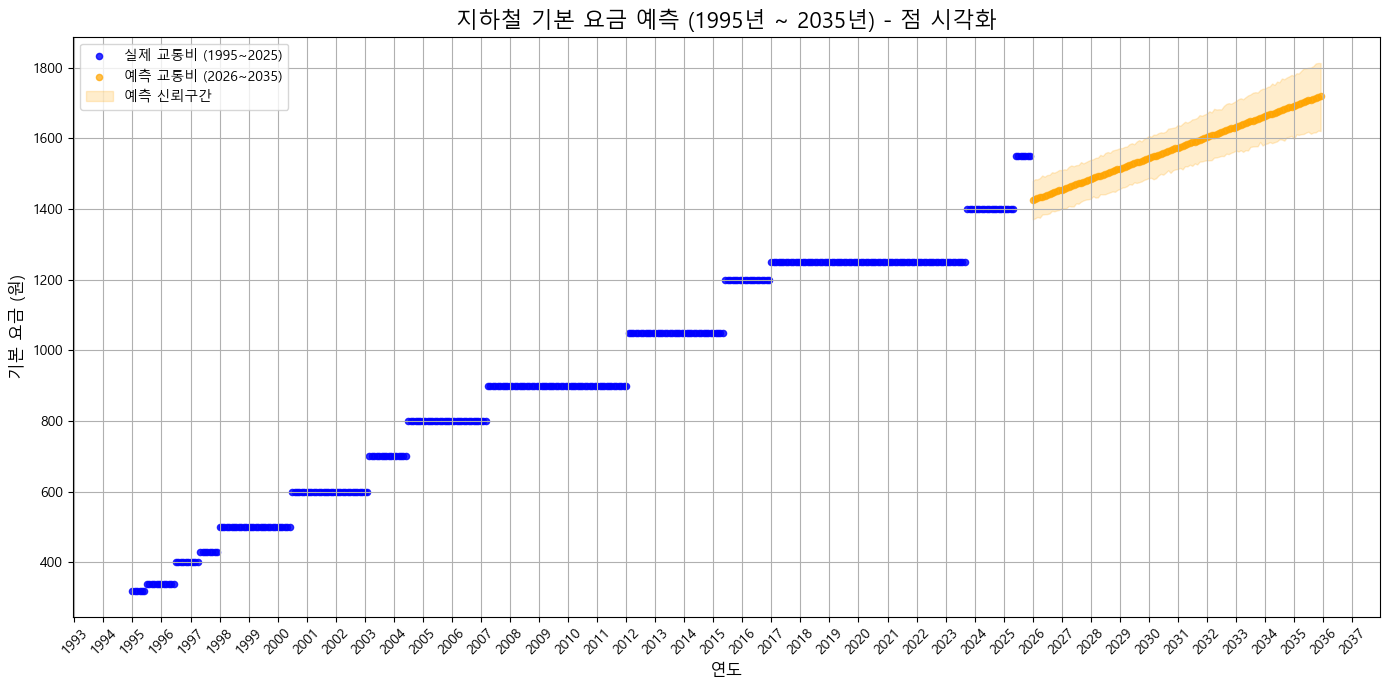

In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd # pandas를 여기서 다시 import 하는 것은 이 셀에서만 실행할 경우 필요

# df_prophet : 1995년 ~ 2025년까지의 실제 월별 교통비 데이터 (ds, y 컬럼)
# forecast : 2026년 ~ 2035년까지의 예측 결과 데이터 (ds, yhat, yhat_lower, yhat_upper)
# 위 변수들이 미리 정의되어 있다고 가정합니다.

# ==============================================================================
# 1. 실제 데이터와 예측 데이터 구간 분리
# ==============================================================================
# 실제 데이터 구간 (1995~2025년)
actual_period = df_prophet 

# 예측 데이터 구간 (2026~2035년)
# df_prophet의 마지막 날짜 이후부터의 forecast 데이터를 가져옵니다.
forecast_period = forecast[forecast['ds'] > actual_period['ds'].max()]


# ==============================================================================
# 2. 시각화 (점(scatter)으로 표현)
# ==============================================================================
fig, ax = plt.subplots(figsize=(14,7))

# 실제 교통비 데이터를 '점(scatter)'으로 표시 (파란색)
ax.scatter(actual_period['ds'], actual_period['y'], 
           label='실제 교통비 (1995~2025)', color='blue', s=20, alpha=0.8) # s는 점 크기

# 예측 교통비 데이터를 '점(scatter)'으로 표시 (주황색)
ax.scatter(forecast_period['ds'], forecast_period['yhat'], 
           label=f'예측 교통비 ({actual_period["ds"].dt.year.max()+1}~2035)', 
           color='orange', s=20, alpha=0.7) # s는 점 크기

# 예측의 신뢰 구간을 음영으로 표시 (이 부분은 선이나 점 대신 영역으로 표현하는 것이 일반적입니다)
ax.fill_between(forecast_period['ds'], forecast_period['yhat_lower'], forecast_period['yhat_upper'],
                color='orange', alpha=0.2, label='예측 신뢰구간') # alpha는 투명도


# ==============================================================================
# 3. 그래프 설정 (제목, 축 라벨, X축 연도 눈금)
# ==============================================================================
ax.set_title(f'지하철 기본 요금 예측 (1995년 ~ 2035년) - 점 시각화', fontsize=16)
ax.set_xlabel('연도', fontsize=12)
ax.set_ylabel('기본 요금 (원)', fontsize=12)

# X축 연도를 1년 단위로 표시하고, 라벨을 45도 회전
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45) # 라벨 회전

ax.legend(loc='upper left') # 범례 위치
ax.grid(True) # 격자 추가

plt.tight_layout() # 그래프 요소들이 겹치지 않도록 자동 조정
plt.show()


In [1]:
#실패한 시각화 파일